In [17]:
#DOES NOT WORK FOR N != 3

#fixed version of code found on:
#guide: https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/terra/qis_adv/quantum_walk.ipynb
#paper: https://arxiv.org/pdf/0706.0304.pdf

import qiskit
from qiskit import *
qiskit.__qiskit_version__

import numpy as np
from qiskit.tools.visualization import plot_histogram, plot_state_city

import matplotlib as mpl

#number of qubits representing walker state
n = 3

#number of iterations
step = 1

qnodes = QuantumRegister(n,'qc')
qsubnodes = QuantumRegister(1,'qanc')
csubnodes = ClassicalRegister(1,'canc')
cnodes = ClassicalRegister(n,'cr')

#n-qubit toffoli
def cnx(qc, *qubits):
    if len(qubits) >= 3:
        last = qubits[-1]
        # A matrix: (made up of a  and Y rotation, lemma4.3)
        qc.crz(np.pi/2, qubits[-2], qubits[-1])
        qc.cu(np.pi/2, 0, 0, 0, qubits[-2],qubits[-1])
        
        # Control not gate
        cnx(qc,*qubits[:-2],qubits[-1])
        
        # B matrix (pposite angle)
        qc.cu(-np.pi/2, 0, 0, 0, qubits[-2], qubits[-1])
        
        # Control
        cnx(qc,*qubits[:-2],qubits[-1])
        
        # C matrix (final rotation)
        qc.crz(-np.pi/2,qubits[-2],qubits[-1])
    elif len(qubits)==3:
        qc.ccx(*qubits)
    elif len(qubits)==2:
        qc.cx(*qubits)
    

#clockwise rotation
def increment_gate(qwc, q, subnode):
  cnx(qwc, subnode, q[2], q[1], q[0])
  cnx(qwc, subnode, q[2], q[1])
  cnx(qwc, subnode, q[2])
  qwc.barrier()
  return qwc

#counterclockwise rotation
def decrement_gate(qwc, q, subnode):
  qwc.x(subnode)
  qwc.x(q[2])
  qwc.x(q[1])
  cnx(qwc, subnode, q[2], q[1], q[0])
  qwc.x(q[1])
  cnx(qwc, subnode, q[2], q[1])
  qwc.x(q[2])
  cnx(qwc, subnode, q[2])
  qwc.x(subnode)
  return qwc


def runQWC(qwc, times):
    for i in range(times):
        #"coinflip" applied to the subnode every iteration
        qwc.h(qsubnodes[0])
        increment_gate(qwc, qnodes, qsubnodes[0])
        decrement_gate(qwc, qnodes, qsubnodes[0])
        qwc.measure(qnodes, cnodes)
    return qwc

def ibmsim(circ):
  sim = Aer.get_backend('aer_simulator')
  return execute(circ, sim, shots=1000).result().get_counts(circ)

qwc = QuantumCircuit(qnodes, qsubnodes, cnodes, csubnodes)
qwc = runQWC(qwc, step)
qwc.draw(output="mpl")
result = ibmsim(qwc)
print(result)
#plot_histogram(result)


{'0 100': 486, '0 111': 514}


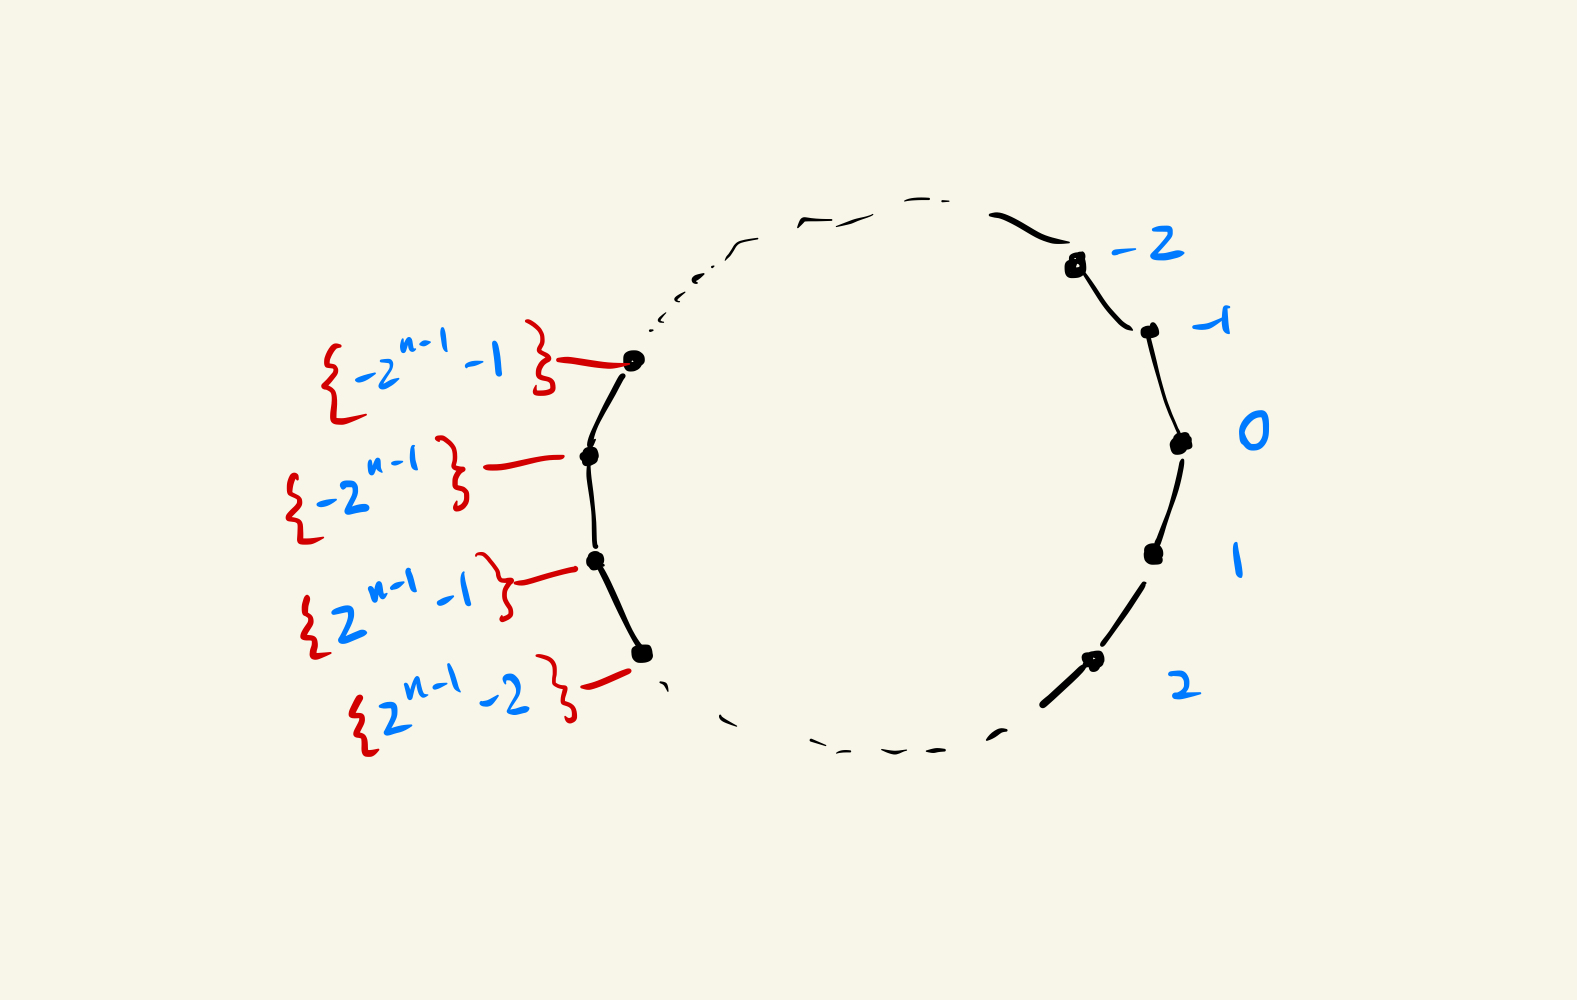

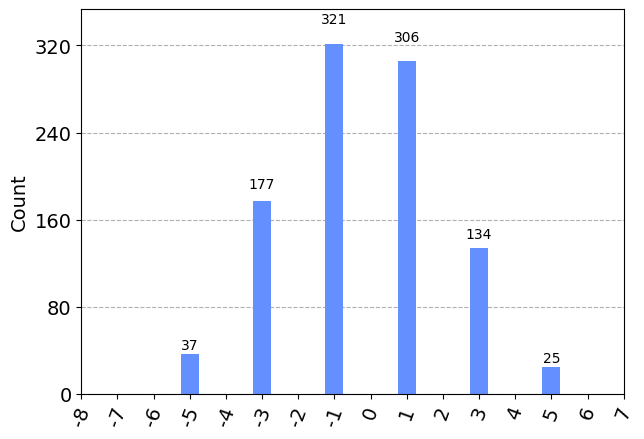

In [1]:
#Works for all n

import qiskit
from qiskit import *
qiskit.__qiskit_version__

import numpy as np
from qiskit.tools.visualization import plot_histogram, plot_state_city

import matplotlib as mpl

#number of qubits representing walker state (2^n states)
#graph node numbers range: [-2^(n-1), +2^(n-1)-1]
n = 4

#number of iterations/walks to be performed
step = 5

qnodes = QuantumRegister(n,'qc')
qsubnodes = QuantumRegister(1,'qanc')
csubnodes = ClassicalRegister(1,'canc')
cnodes = ClassicalRegister(n,'cr')

#n-qubit toffoli
def cnx(qc, qubits):
    if len(qubits) >= 3:
        last = qubits[-1]
        # A matrix: (made up of a  and Y rotation, lemma4.3)
        qc.crz(np.pi/2, qubits[-2], qubits[-1])
        qc.cu(np.pi/2, 0, 0, 0, qubits[-2],qubits[-1])
        
        # Control not gate
        temp = qubits[:-2]
        temp.append(qubits[-1])
        cnx(qc, temp)
        
        # B matrix (pposite angle)
        qc.cu(-np.pi/2, 0, 0, 0, qubits[-2], qubits[-1])
        
        # Control
        cnx(qc, temp)
        
        # C matrix (final rotation)
        qc.crz(-np.pi/2,qubits[-2],qubits[-1])
    elif len(qubits)==3:
        qc.ccx(*qubits)
    elif len(qubits)==2:
        qc.cx(*qubits)
    

#clockwise rotation, adder circuit like
def increment_gate(qwc, q, subnode):
    #investigate whether increment can be done in a simpler way:
    #can use a adder circuit or will this mess with the algorithm?
    for i in range(len(q)):
        #multi-qubit tolfolli, target i, control by subnode & all bits of lesser significance
        target = q[i]
        qubits = q[i + 1 : len(q) + 1]
        qubits.insert(0, subnode)
        qubits.append(target)
        #print(qubits)
        cnx(qwc, qubits)
    qwc.barrier()
    return qwc

#counterclockwise rotation, subtractor circuit like
def decrement_gate(qwc, q, subnode):
    qwc.x(subnode)
    for i in range(1, len(q)):
        qwc.x(q[i])
    temp = q[1 : len(q) + 1]
    temp.insert(0, subnode)
    temp.append(q[0])
    #print(temp)
    cnx(qwc, temp)
    for i in range(1, len(q)):
        target = q[i]
        qubits = q[i + 1 : len(q) + 1]
        qubits.insert(0, subnode)
        qubits.append(target)
        #print(qubits)
        qwc.x(target)
        cnx(qwc, qubits)
    qwc.x(subnode)
    return qwc

def ibmsim(circ):
  sim = Aer.get_backend('aer_simulator')
  return execute(circ, sim, shots=1000).result().get_counts(circ)

def runQWC(qwc, times):
    for i in range(times):
        #"coinflip" applied to the subnode every iteration
        qwc.h(qsubnodes[0])
        increment_gate(qwc, qnodes, qsubnodes[0])
        decrement_gate(qwc, qnodes, qsubnodes[0])
        qwc.measure(qnodes, cnodes)
    return qwc

qwc = QuantumCircuit(qnodes, qsubnodes, cnodes, csubnodes)
qwc.x(qsubnodes[0])
qwc = runQWC(qwc, step)
qwc.draw(output="mpl")
result = ibmsim(qwc)
#big endian output

newResult = {}
showAll = True;
#remove this if too cluttered
if (showAll):
    for i in range(-(2 ** (n - 1)), 2 ** (n - 1)):
        newResult[i] = 0
    
for r in result:
    b = r.split( )[1]
    b = b[::-1]
    dec = int(b, 2)
    if (b[0] == "1"):
        dec -= 2 ** len(b) 
    newResult[dec] = result[r]

plot_histogram(newResult)